In [1]:
import os
import pickle
import math
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

In [2]:
config = {
    'dataset': 'uklex18', # choices=['uklex18', 'uklex69', 'eurlex21', 'eurlex127', 'ecthr_a', 'ecthr_b']
    'method': 'erm', # choices=['erm', 'ewc', 'er', 'agem', 'lora', 'adapter', 'coral', 'irm', 'groupdro']
    'device': 0,  # 'gpu id'
    'random_seed': 1,  # 'random seed number'

    # Logging, saving, and testing options
    'data_dir': './data',  # 'directory for datasets.'
    'log_dir': './checkpoints',  # 'directory for summaries and checkpoints.'
    'results_dir': './results',  # 'directory for summaries and checkpoints.'
    'num_workers': 0  # 'number of workers in data generator'
}
from munch import DefaultMunch
args = DefaultMunch.fromDict(config)

In [23]:
PREPROCESSED_FILE = 'uklex18.pkl'
MAX_TOKEN_LENGTH = 512
RAW_DATA_FILE = 'uk-lex18.jsonl'
ID_HELD_OUT = 0.2
GROUP = 7

In [24]:
raw_data_path = os.path.join(args.data_dir, RAW_DATA_FILE)
if not os.path.isfile(raw_data_path):
    raise ValueError(f'{RAW_DATA_FILE} is not in the data directory {args.data_dir}!')

# Load data frame from json file, group by year
base_df = pd.read_json(raw_data_path, lines=True)
base_df = base_df.sort_values(by=['year'])
base_df

,id,year,labels,title,body,data_type
0,UKSI19750515,1975,[SOCIAL SECURITY],The Social Security (Guardian's Allowances) Re...,"Citation, commencement and interpretation\n1 1...",train
1,UKSI19761267,1976,[SOCIAL SECURITY],The Child Benefit and Social Security (Fixing ...,"Citation, commencement and interpretation\n1 1...",train
2,UKSI19760965,1976,[SOCIAL SECURITY],The Child Benefit (General) Regulations 1976,"PART I\nGeneral\nCitation, commencement and in...",train
3,UKSI19790628,1979,[SOCIAL SECURITY],The Social Security (Claims and Payments) Regu...,P art I\nGENERAL\nCitation and commencement\n1...,train
4,UKSI19821163,1982,[TRANSPORTATION],The Motorways Traffic (England and Wales) Regu...,Commencement and citation\n1\nThese Regulation...,train
...,...,...,...,...,...,...
36450,UKSI20180626,2018,[SOCIAL SECURITY],The Scotland Act 1998 (Agency Arrangements) (S...,Citation\n1\nThis Order may be cited as the Sc...,test
36449,UKSI20180431,2018,[HEALTH CARE],The Plymouth Hospitals National Health Service...,"Citation, commencement and interpretation\n1\n...",test
36448,UKSI20180061,2018,[SOCIAL SECURITY],The Social Fund Funeral Expenses Amendment Reg...,Citation and commencement\n1\nThese Regulation...,test
36454,UKSI20180221,2018,[HOUSING],The Licensing of Houses in Multiple Occupation...,Citation and Commencement\n1\n1\nThis Order ma...,test


In [25]:
df_years = base_df.groupby(pd.Grouper(key='data_type'))
all_dfs = [group for _, group in df_years]
# all_years = list(base_df['data_type'].unique())
all_dfs = [all_dfs[0][:10000], all_dfs[0][10000:], all_dfs[1], all_dfs[2]]

categories_to_classids = {category: classid for classid, category in
                              enumerate(sorted(list(set([i for sublist in base_df['labels'] for i in sublist]))))}
classids_to_categories = {v: k for k, v in categories_to_classids.items()}


In [26]:
classids_to_categories

{0: 'AGRICULTURE & FOOD',
 1: 'CHILDREN',
 2: 'CRIMINAL LAW',
 3: 'EDUCATION',
 4: 'ENVIRONMENT',
 5: 'EU',
 6: 'FINANCE',
 7: 'HEALTH CARE',
 8: 'HOUSING',
 9: 'IMMIGRATION & CITIZENSHIP',
 10: 'LOCAL GOVERNMENT',
 11: 'PLANNING & DEVELOPMENT',
 12: 'POLITICS',
 13: 'PUBLIC ORDER',
 14: 'SOCIAL SECURITY',
 15: 'TAXATION',
 16: 'TELECOMMUNICATIONS',
 17: 'TRANSPORTATION'}

In [32]:
for i in range(4):
    keep = []
    for j in range(len(dfs[i])):
        if classids_to_categories[1] in dfs[i].iloc[j, 2]:
            keep.append(j)
    dfs[i] = dfs[i].iloc[keep, :]

In [53]:
len(dfs)

3

In [7]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
remove_these = set(stopwords.words('english') + list(string.punctuation) + list(string.digits))
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to /Users/luke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/luke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
import numpy as np
import pandas as pd
from collections import Counter
import collections
import ast

In [9]:
# labels_counts = {}
# for i in range(4):
#     dfs[i]['tokenized'] = dfs[i]['body'].apply(tokenizer.tokenize)
#     labels = [label for lbs in dfs[i]['tokenized'] for label in lbs]
#     all_labels = [w for w in labels if not w in remove_these]
#     labels_count = Counter(all_labels)
#     labels_counts[i+1] = labels_count


def jaccard_set(list1, list2):
    """Define Jaccard Similarity function for two sets"""
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# mat = []
# for k1, p in labels_counts.items():
#     sub = []
#     for k2, q in labels_counts.items():
#         kl_pq = jaccard_set(p.keys(), q.keys())
#         sub.append(kl_pq)
#     mat.append(sub)
# np.round(mat, 4)

In [11]:
# allowed = labels_counts[1].keys() & labels_counts[2].keys() & labels_counts[3].keys() & labels_counts[4].keys()
#
# for i in range(4):
#     entries_to_remove = labels_counts[i+1].keys() - allowed
#     for k in entries_to_remove:
#         labels_counts[i+1].pop(k, None)
#     od = collections.OrderedDict(sorted(labels_counts[i+1].items()))
#     labels_counts[i+1] = list(od.values())

from math import log2
from scipy.special import rel_entr, kl_div
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))
#
# mat = []
# for k1, p in labels_counts.items():
#     sub = []
#     for k2, q in labels_counts.items():
#         # print('P =', k1, ', Q =', k2)
#         # calculate (P || Q)
#         p = np.asarray(p)
#         q = np.asarray(q)
#         kl_pq = jensenshannon(p, q, base=2)
#         sub.append(kl_pq)
#         # print('KL(P|Q): %.3f' % kl_pq)
#         # # calculate (Q || P)
#         # kl_qp = rel_entr(q, p)
#         # print('KL(Q || P): %.3f bits' % sum(kl_pq))
#     mat.append(sub)
# np.round(mat, 4)

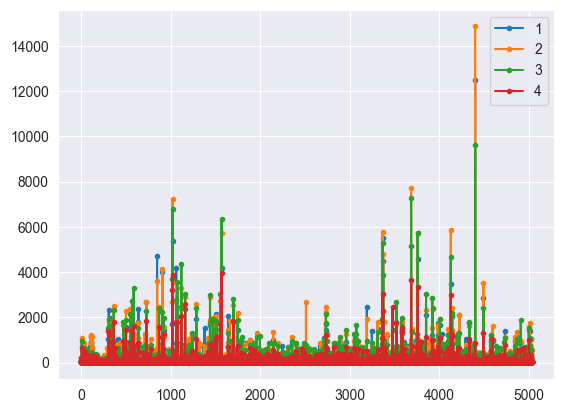

In [30]:
import matplotlib.pyplot as plt

for k, v in labels_counts.items():
    plt.plot(range(0, len(v)), v, '.-', label=k)
    # NOTE: changed `range(1, 4)` to mach actual values count
plt.legend()  # To draw legend
plt.show()

In [28]:
m = None
n = None
for l in range(18):
    print(classids_to_categories[l])
    dfs = [i.copy() for i in all_dfs]
    for i in range(4):
        keep = []
        for j in range(len(dfs[i])):
            if classids_to_categories[l] in dfs[i].iloc[j, 2]:
                keep.append(j)
        if len(keep) == 0:
            keep = [0]
        dfs[i] = dfs[i].iloc[keep, :]

    labels_counts = {}
    for i in range(4):
        dfs[i]['tokenized'] = dfs[i]['body'].apply(tokenizer.tokenize)
        labels = [label for lbs in dfs[i]['tokenized'] for label in lbs]
        all_labels = [w for w in labels if not w in remove_these]
        labels_count = Counter(all_labels)
        labels_counts[i+1] = labels_count

    mat = []
    for k1, p in labels_counts.items():
        sub = []
        for k2, q in labels_counts.items():
            kl_pq = jaccard_set(p.keys(), q.keys())
            sub.append(kl_pq)
        mat.append(sub)
    if m is None:
        m = np.round(mat, 4)
    else:
        m = np.concatenate((m, np.round(mat, 4)), axis=0)

    allowed = labels_counts[1].keys() & labels_counts[2].keys() & labels_counts[3].keys() & labels_counts[4].keys()

    for i in range(4):
        entries_to_remove = labels_counts[i+1].keys() - allowed
        for k in entries_to_remove:
            labels_counts[i+1].pop(k, None)
        od = collections.OrderedDict(sorted(labels_counts[i+1].items()))
        labels_counts[i+1] = list(od.values())

    mat = []
    for k1, p in labels_counts.items():
        sub = []
        for k2, q in labels_counts.items():
            p = np.asarray(p)
            q = np.asarray(q)
            kl_pq = jensenshannon(p, q, base=2)
            sub.append(kl_pq)
        mat.append(sub)

    if n is None:
        n = np.round(mat, 4)
    else:
        n = np.concatenate((n, np.round(mat, 4)), axis=0)

AGRICULTURE & FOOD
CHILDREN
CRIMINAL LAW
EDUCATION
ENVIRONMENT
EU
FINANCE
HEALTH CARE
HOUSING
IMMIGRATION & CITIZENSHIP
LOCAL GOVERNMENT
PLANNING & DEVELOPMENT
POLITICS
PUBLIC ORDER
SOCIAL SECURITY
TAXATION
TELECOMMUNICATIONS
TRANSPORTATION


In [30]:
n

array([[0.    , 0.2573, 0.3261, 0.3759],
       [0.2573, 0.    , 0.2462, 0.3356],
       [0.3261, 0.2462, 0.    , 0.264 ],
       [0.3759, 0.3356, 0.264 , 0.    ],
       [0.    , 0.2459, 0.2995, 0.3504],
       [0.2459, 0.    , 0.2592, 0.3128],
       [0.2995, 0.2592, 0.    , 0.2362],
       [0.3504, 0.3128, 0.2362, 0.    ],
       [0.    , 0.2933, 0.3648, 0.4528],
       [0.2933, 0.    , 0.2918, 0.427 ],
       [0.3648, 0.2918, 0.    , 0.3655],
       [0.4528, 0.427 , 0.3655, 0.    ],
       [0.    , 0.2282, 0.3036, 0.3461],
       [0.2282, 0.    , 0.2306, 0.3085],
       [0.3036, 0.2306, 0.    , 0.231 ],
       [0.3461, 0.3085, 0.231 , 0.    ],
       [0.    , 0.2907, 0.3637, 0.4043],
       [0.2907, 0.    , 0.2521, 0.3495],
       [0.3637, 0.2521, 0.    , 0.271 ],
       [0.4043, 0.3495, 0.271 , 0.    ],
       [0.    , 0.3118, 0.3449, 0.3797],
       [0.3118, 0.    , 0.2526, 0.3073],
       [0.3449, 0.2526, 0.    , 0.2712],
       [0.3797, 0.3073, 0.2712, 0.    ],
       [0.    , 

# ECTHR

In [36]:
PREPROCESSED_FILE = 'ecthr_a.pkl'
MAX_TOKEN_LENGTH = 128
RAW_DATA_FILE = ['ecthr-train.jsonl', 'ecthr-dev.jsonl', 'ecthr-test.jsonl']
ID_HELD_OUT = 0.2
GROUP = 1

In [42]:
base_dfs = []
for path in RAW_DATA_FILE:
    raw_data_path = os.path.join(args.data_dir, path)
    if not os.path.isfile(raw_data_path):
        raise ValueError(f'{path} is not in the data directory {args.data_dir}!')
    base_dfs.append(pd.read_json(raw_data_path, lines=True))
# Load data frame from json file, group by year
# base_df = pd.concat(base_dfs)
base_dfs[0] = base_dfs[0].sort_values(by=['judgment_date'])

dfs = [base_dfs[0][:4500], base_dfs[0][4500:], base_dfs[1], base_dfs[2]]

# allowed = ['10', '11', '13', '14', '2', '3', '5', '6', '7', '8', '9', 'P1-1', 'P1-3', 'P4-2']
allowed = ['10', '11', '13', '14', '18', '2', '3', '4', '5', '6', '7', '8', '9', 'P1-1', 'P4-2', 'P7-1', 'P7-4']
all_dfs = []
for base_df in dfs:
    for i in range(len(base_df)):
        new_label = []
        for label in base_df.iloc[i, 7]:
            if label in allowed:
                new_label.append(label)
        base_df.iloc[i, 7] = new_label
    all_dfs.append(base_df)
# base_df['year'] = pd.DatetimeIndex(base_df['judgment_date']).year
# df_years = base_df.groupby(pd.Grouper(key='year'))
# all_dfs = [group for _, group in df_years]

/var/folders/q2/1cpqcsg57hvbmp5m3k_76c000000gn/T/ipykernel_36701/963854241.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df.iloc[i, 7] = new_label


In [43]:
categories_to_classids = {category: classid for classid, category in
                              enumerate(sorted(list(set([i for sublist in all_dfs[0]['allegedly_violated_articles'] for i in sublist]))))}
classids_to_categories = {v: k for k, v in categories_to_classids.items()}
classids_to_categories

{0: '10',
 1: '11',
 2: '13',
 3: '14',
 4: '18',
 5: '2',
 6: '3',
 7: '4',
 8: '5',
 9: '6',
 10: '7',
 11: '8',
 12: '9',
 13: 'P1-1',
 14: 'P4-2',
 15: 'P7-1',
 16: 'P7-4'}

In [44]:
m = None
n = None
for l in range(17):
    print(classids_to_categories[l])
    dfs = [i.copy() for i in all_dfs]
    for i in range(4):
        keep = []
        for j in range(len(dfs[i])):
            if classids_to_categories[l] in dfs[i].iloc[j, 7]:
                keep.append(j)
        if len(keep) == 0:
            keep = [0]
        dfs[i] = dfs[i].iloc[keep, :]

    labels_counts = {}
    for i in range(4):
        dfs[i]['body'] = dfs[i]['facts'].apply(' '.join)
        dfs[i]['tokenized'] = dfs[i]['body'].apply(tokenizer.tokenize)
        labels = [label for lbs in dfs[i]['tokenized'] for label in lbs]
        all_labels = [w for w in labels if not w in remove_these]
        labels_count = Counter(all_labels)
        labels_counts[i+1] = labels_count

    mat = []
    for k1, p in labels_counts.items():
        sub = []
        for k2, q in labels_counts.items():
            kl_pq = jaccard_set(p.keys(), q.keys())
            sub.append(kl_pq)
        mat.append(sub)
    if m is None:
        m = np.round(mat, 4)
    else:
        m = np.concatenate((m, np.round(mat, 4)), axis=0)

    allowed = labels_counts[1].keys() & labels_counts[2].keys() & labels_counts[3].keys() & labels_counts[4].keys()

    for i in range(4):
        entries_to_remove = labels_counts[i+1].keys() - allowed
        for k in entries_to_remove:
            labels_counts[i+1].pop(k, None)
        od = collections.OrderedDict(sorted(labels_counts[i+1].items()))
        labels_counts[i+1] = list(od.values())

    mat = []
    for k1, p in labels_counts.items():
        sub = []
        for k2, q in labels_counts.items():
            p = np.asarray(p)
            q = np.asarray(q)
            kl_pq = jensenshannon(p, q, base=2)
            sub.append(kl_pq)
        mat.append(sub)

    if n is None:
        n = np.round(mat, 4)
    else:
        n = np.concatenate((n, np.round(mat, 4)), axis=0)

10
11
13
14
18
2
3
4
5
6
7
8
9
P1-1
P4-2
P7-1
P7-4


In [46]:
m

array([[1.    , 0.3655, 0.2948, 0.3181],
       [0.3655, 1.    , 0.3269, 0.3433],
       [0.2948, 0.3269, 1.    , 0.3491],
       [0.3181, 0.3433, 0.3491, 1.    ],
       [1.    , 0.3931, 0.3012, 0.3424],
       [0.3931, 1.    , 0.2967, 0.3315],
       [0.3012, 0.2967, 1.    , 0.3693],
       [0.3424, 0.3315, 0.3693, 1.    ],
       [1.    , 0.3676, 0.2464, 0.272 ],
       [0.3676, 1.    , 0.2667, 0.2905],
       [0.2464, 0.2667, 1.    , 0.3847],
       [0.272 , 0.2905, 0.3847, 1.    ],
       [1.    , 0.3792, 0.2425, 0.2343],
       [0.3792, 1.    , 0.276 , 0.2653],
       [0.2425, 0.276 , 1.    , 0.3732],
       [0.2343, 0.2653, 0.3732, 1.    ],
       [1.    , 0.3204, 0.2144, 0.2884],
       [0.3204, 1.    , 0.2886, 0.3266],
       [0.2144, 0.2886, 1.    , 0.304 ],
       [0.2884, 0.3266, 0.304 , 1.    ],
       [1.    , 0.3728, 0.3159, 0.3017],
       [0.3728, 1.    , 0.3039, 0.2849],
       [0.3159, 0.3039, 1.    , 0.3944],
       [0.3017, 0.2849, 0.3944, 1.    ],
       [1.    , 

In [ ]:
import matplotlib.pyplot as plt

for k, v in labels_counts.items():
    plt.plot(range(0, len(v)), v, '.-', label=k)
    # NOTE: changed `range(1, 4)` to mach actual values count
plt.legend()  # To draw legend
plt.show()

# EURLEX

In [55]:
from datasets import load_dataset
dataset = load_dataset('multi_eurlex', language='en', label_level='level_1')

Found cached dataset multi_eurlex (/Users/luke/.cache/huggingface/datasets/multi_eurlex/default-label_level=level_1,language=en/1.0.0/5a12a7463045d4dcb12896b478c09b5a8a131a02b7e7bce059ba7ececc6584ee)


  0%|          | 0/3 [00:00<?, ?it/s]

In [56]:
import re
all_dfs = []

splits = ['train', 'validation', 'test']
for x in splits:
    df = pd.DataFrame(columns=['celex_id', 'text', 'labels', 'year'])
    for i in dataset[x]:
        valid_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                        "October", "November", "December"]
        pattern = r'(\d{1,2})\s*(' + '|'.join(valid_months) + ')\s*(\d{4})'
        # matches = list(re.finditer(pattern, i['title'], re.IGNORECASE))

        # if len(matches) > 0:
        #     year = matches[0].group(3)
        # else:
        #
        matches = list(re.finditer(pattern, i['text'], re.IGNORECASE))
        if len(matches) > 0:
            year = matches[0].group(3)
        # else:
            # print(i['celex_id'], i['text'][:100], '\n')
        elif i['celex_id'] == '31988R0091':
            year = 1988
        elif i['celex_id'] in ['31987D0594', '31987D0593']:
            year = 1987

        df.loc[len(df)] = list(i.values()) + [int(year)]
    df = df.sort_values(by=['year'])
    if x == 'train':
        all_dfs += [df[:27500], df[27500:]]
    else:
        all_dfs.append(df)

# categories_to_classids = {category: classid for classid, category in
#                               enumerate(sorted(list(set([i for sublist in all_dfs[1]['labels'] for i in sublist]))))}
# classids_to_categories = {v: k for k, v in categories_to_classids.items()}


In [57]:
categories_to_classids = {category: classid for classid, category in
                              enumerate(sorted(list(set([i for sublist in all_dfs[1]['labels'] for i in sublist]))))}
classids_to_categories = {v: k for k, v in categories_to_classids.items()}
classids_to_categories

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20}

In [58]:
m = None
n = None
for l in range(21):
    print(classids_to_categories[l])
    dfs = [i.copy() for i in all_dfs]
    for i in range(4):
        keep = []
        for j in range(len(dfs[i])):
            if classids_to_categories[l] in dfs[i].iloc[j, 2]:
                keep.append(j)
        if len(keep) == 0:
            keep = [0]
        dfs[i] = dfs[i].iloc[keep, :]

    labels_counts = {}
    for i in range(4):
        dfs[i]['tokenized'] = dfs[i]['text'].apply(tokenizer.tokenize)
        labels = [label for lbs in dfs[i]['tokenized'] for label in lbs]
        all_labels = [w for w in labels if not w in remove_these]
        labels_count = Counter(all_labels)
        labels_counts[i+1] = labels_count

    mat = []
    for k1, p in labels_counts.items():
        sub = []
        for k2, q in labels_counts.items():
            kl_pq = jaccard_set(p.keys(), q.keys())
            sub.append(kl_pq)
        mat.append(sub)
    if m is None:
        m = np.round(mat, 4)
    else:
        m = np.concatenate((m, np.round(mat, 4)), axis=0)

    allowed = labels_counts[1].keys() & labels_counts[2].keys() & labels_counts[3].keys() & labels_counts[4].keys()

    for i in range(4):
        entries_to_remove = labels_counts[i+1].keys() - allowed
        for k in entries_to_remove:
            labels_counts[i+1].pop(k, None)
        od = collections.OrderedDict(sorted(labels_counts[i+1].items()))
        labels_counts[i+1] = list(od.values())

    mat = []
    for k1, p in labels_counts.items():
        sub = []
        for k2, q in labels_counts.items():
            p = np.asarray(p)
            q = np.asarray(q)
            kl_pq = jensenshannon(p, q, base=2)
            sub.append(kl_pq)
        mat.append(sub)

    if n is None:
        n = np.round(mat, 4)
    else:
        n = np.concatenate((n, np.round(mat, 4)), axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [60]:
m

array([[1.    , 0.3631, 0.3211, 0.3252],
       [0.3631, 1.    , 0.3699, 0.3646],
       [0.3211, 0.3699, 1.    , 0.461 ],
       [0.3252, 0.3646, 0.461 , 1.    ],
       [1.    , 0.3335, 0.2473, 0.249 ],
       [0.3335, 1.    , 0.3049, 0.2984],
       [0.2473, 0.3049, 1.    , 0.4674],
       [0.249 , 0.2984, 0.4674, 1.    ],
       [1.    , 0.3911, 0.3337, 0.3365],
       [0.3911, 1.    , 0.3687, 0.3888],
       [0.3337, 0.3687, 1.    , 0.4998],
       [0.3365, 0.3888, 0.4998, 1.    ],
       [1.    , 0.3326, 0.2378, 0.2551],
       [0.3326, 1.    , 0.2914, 0.3111],
       [0.2378, 0.2914, 1.    , 0.4341],
       [0.2551, 0.3111, 0.4341, 1.    ],
       [1.    , 0.3343, 0.2646, 0.2616],
       [0.3343, 1.    , 0.2752, 0.2667],
       [0.2646, 0.2752, 1.    , 0.4593],
       [0.2616, 0.2667, 0.4593, 1.    ],
       [1.    , 0.3847, 0.3248, 0.3426],
       [0.3847, 1.    , 0.3302, 0.3638],
       [0.3248, 0.3302, 1.    , 0.4894],
       [0.3426, 0.3638, 0.4894, 1.    ],
       [1.    , 